# Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns

# Utilities
import pickle
import copy
import time

from fuzzy_match import match
from fuzzy_match import algorithims

# Custom functions

In [2]:
from utils import *

# Import data

## Cross-holdings

In [4]:
# Parameters
base_path = './Data/Large_network/Cross_holdings'
dates = ["2019-12-31","2020-03-16","2020-06-30","2020-09-30","2020-12-31"]

# Initialize dictionary of dataframes
df_dict = {}

for datep in dates:
    date = datep.replace("-","")
    temp_list = []
    for batch in range(1,3):
        final_path = base_path + "/batch{}_".format(batch) + date + ".xlsx"
        df = pd.read_excel(final_path,skiprows=4)
        
        if batch == 1:
            df = df.iloc[:,:69]
        else:
            df = df.iloc[:,:27]
            
        
        temp_list.append(df)
        
    df = temp_list[0].merge(temp_list[1], how = 'outer', left_on="Name", right_on="Name")

    
    df_dict[datep] = df

In [5]:
# for key, val in df_dict.items():
    
#     print(key)
#     print(val.head())
#     print(val.shape)

## Ticker names

In [6]:
df = pd.read_csv('./Data/Large_network/largenet_log_ret.csv',sep=",", header=0)

#print(df.head())

In [7]:
var_names = list(df.columns)[1:]

#print(var_names)

In [8]:
var_metadata = pd.read_excel('./Data/Stock_prices/Bank_tickers.xlsx')

#print(var_metadata.head())
#print(var_metadata.shape)

# Data preprocessing

In [9]:
# Filter for those banks who are in the final list
var_metadata = var_metadata[var_metadata['Yahoo Finance Ticker'].isin(var_names)]
#print(var_metadata.shape)

In [10]:
tickers = list(var_metadata['Bank Code'])

names = list(var_metadata['Bank Name'])

orig_tickers = copy.deepcopy(tickers)
tickers = [ ticker.replace('.', '-').upper() for ticker in tickers]

ticker_name_dict = {}

for i in range(0,len(tickers)):
    ticker_name_dict[tickers[i]] = names[i]
    
#print(ticker_name_dict)

## Fuzzy matching

In [11]:
# Parameters
df_dict = df_dict
ticker_name_dict = ticker_name_dict
dates = ['2020-09-30'] # ["2019-12-31","2020-03-16","2020-06-30","2020-09-30","2020-12-31"]
match_type = 'trigram'
score_cutoff = 0.5
n = len(ticker_name_dict.keys())

# Initialize dictionary to store the final cross-holdings networks
final_ch_networks = {}

In [12]:
for date in dates:
    
    print(date)
    
    start = time.time()
    
    # Get dataframe of the current date
    df = df_dict[date]

    # Get potential holder name choices
    choices = df.Name
    
    ch_array = np.zeros((n,n))

    for i in range(0,n):
        for j in range(0,n):

            # Get current tickers
            holder_ticker = tickers[i]
            stock_ticker = tickers[j]

            # Add score to the array
            ch_array[i,j] = cross_holdings_computer(df, choices, ticker_name_dict, stock_ticker, holder_ticker,
                                match_type,score_cutoff)
            
            
    # Add current network to the dictionary
    final_ch_networks[date] = ch_array

    end = time.time()
    runtime = round(end-start,2)
    print("Time elapsed: {} seconds".format(runtime))

2020-09-30
Time elapsed: 1209.02 seconds


# Visualize cross-holdings networks

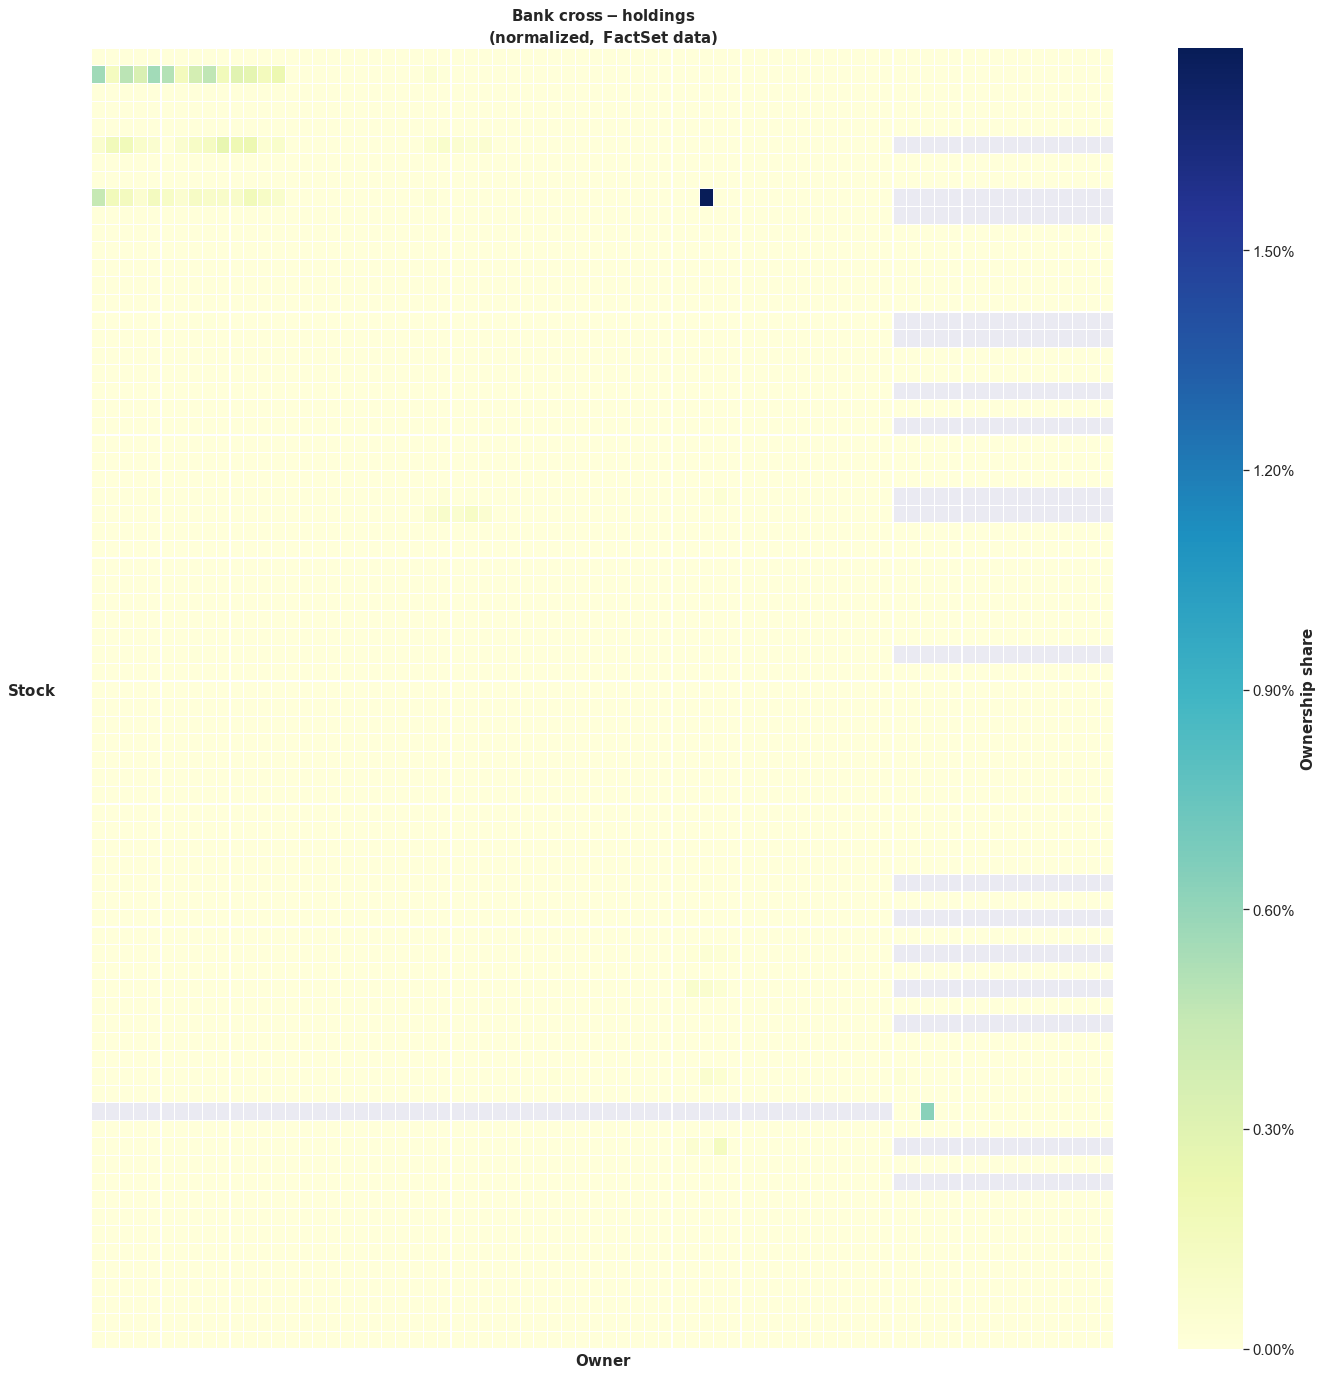

In [28]:
# Parameters
figsize = 20
offset = 0
save_dpi = 120

# Loop over cross-holdings networks at different time points
for date, ch_array in final_ch_networks.items():
    
    plt.rcParams['figure.figsize'] = (figsize,figsize)

    n, d = ch_array.shape

    x_labels = [names[i] for i in range(0,d)]
    x_places = [i+offset for i in range(0,d)]

    y_labels = [names[i] for i in range(0,n)]
    y_places = [i+offset for i in range(0,n)]

    sns.set(font_scale=3)
    ax = sns.heatmap(ch_array*100, linewidth=0.1, cmap="YlGnBu",
                cbar_kws={'format': '%.2f%%'}, xticklabels=False, yticklabels=False)
    plt.xlabel(r"$\bf{Owner}$",fontsize=15)
    #plt.yticks(y_places,y_labels, rotation=0)
    #plt.xticks(x_places,x_labels, rotation=90)
    plt.ylabel(r"$\bf{Stock}$",fontsize=15, rotation=0,labelpad=60)
    plt.title(r"$\bf{Bank\ cross-holdings}$" + "\n" + r"$\bf{(normalized,\ FactSet\ data)}$",fontsize=15)
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.figure.axes[-1].set_ylabel(r'$\bf{Ownership\ share}$', size=15)
    
    cbar = ax.collections[0].colorbar
    # here set the labelsize by 20
    cbar.ax.tick_params(labelsize=15)
    
    #cbar.ax.tick_params(labelsize=10) 


    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom, top)

    plt.tight_layout()
    plt.savefig('./Figures/Large_network/CrossHoldings_{}.pdf'.format(date),dpi=save_dpi)
    plt.show()

# Export final cross-holdings tables

In [29]:
# Save results as csv files
for date, ch_array in final_ch_networks.items():
    
    n, d = ch_array.shape
    
    df = pd.DataFrame(ch_array)
    df.columns = orig_tickers[:n]
    df.index = orig_tickers[:n]
    df.to_csv('./Data/Large_network/Cross_holdings/final_CH_network_{}.csv'.format(date))

# Support

In [ ]:
stock_ticker = 'JPM-US'
holder_ticker = 'BAC-US'

In [75]:
# #%%time

# start = time.time()

# # Initialize array to store the results
# n = len(ticker_name_dict.keys())

# n = 20

# ch_array = np.zeros((n,n))

# for i in range(0,n):
#     for j in range(0,n):
        
#         # Get current tickers
#         holder_ticker = tickers[i]
#         stock_ticker = tickers[j]
        
#         # Add score to the array
#         ch_array[i,j] = cross_holdings_computer(df, choices, ticker_name_dict, stock_ticker, holder_ticker,
#                             match_type,score_cutoff)
        
# end = time.time()
# runtime = round(end-start,2)
# print("Time elapsed: {} seconds".format(runtime))

In [76]:
df = pd.DataFrame(ch_array)
df.columns = orig_tickers[:n]
df.index = orig_tickers[:n]


df.to_csv('./Data/Large_network/Cross_holdings/final_CH_network_{}.csv'.format(date))

In [43]:
choices = df_dict['2020-09-30'].Name #names
matches = match.extract("Vanguard", choices, match_type='trigram', score_cutoff=0.3)

In [44]:
matches

[('The Vanguard Group, Inc.', 0.391304),
 ('Vanguard Fiduciary Trust Co.', 0.321429),
 ('Vanguard Global Advisers LLC', 0.310345)]

In [46]:
match_names = [match[0] for match in matches]
np.sum(temp_df[temp_df['Name'].isin(match_names)]['JPM-US'].values)

In [47]:
temp_df = df_dict['2020-09-30']

In [52]:
np.sum(temp_df[temp_df['Name'].isin(match_names)]['JPM-US'].values)

7.881

In [21]:
float(df_dict['2020-09-30'][df_dict['2020-09-30']['Name']=='The Vanguard Group, Inc.']['JPM-US'])
#df[df['Name']==name][stock_ticker]

7.5115

In [33]:
len(ticker_name_dict.keys())

94

In [ ]:
#cross_holdings_computer(df_dict, ticker_name_dict, stock_ticker, holder_ticker, date, match_type,score_cutoff)

In [103]:
#epsilon = np.nextafter(0, 1)

#ch_array[ch_array==0] = epsilon

In [104]:
for key, val in final_ch_networks.items():
    plt.imshow(ch_array, cmap='viridis')
    plt.colorbar()
    plt.tight_layout()
    plt.savefig()
    plt.show()

NameError: name 'final_ch_networks' is not defined